<a href="https://colab.research.google.com/github/MasterNathan01/4106/blob/main/WatersNathan_801283595_HW1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
Files already downloaded and verified
Training started...
Epoch [1/20], Train Loss: 1.6604, Train Acc: 40.79%, Val Loss: 1.5179, Val Acc: 46.43%
Epoch [2/20], Train Loss: 1.4449, Train Acc: 48.94%, Val Loss: 1.4498, Val Acc: 48.31%
Epoch [3/20], Train Loss: 1.3305, Train Acc: 53.17%, Val Loss: 1.3887, Val Acc: 51.26%
Epoch [4/20], Train Loss: 1.2443, Train Acc: 56.20%, Val Loss: 1.3621, Val Acc: 52.36%
Epoch [5/20], Train Loss: 1.1696, Train Acc: 58.60%, Val Loss: 1.3622, Val Acc: 52.05%
Epoch [6/20], Train Loss: 1.1077, Train Acc: 60.68%, Val Loss: 1.3446, Val Acc: 53.54%
Epoch [7/20], Train Loss: 1.0447, Train Acc: 63.03%, Val Loss: 1.3671, Val Acc: 53.51%
Epoch [8/20], Train Loss: 0.9844, Train Acc: 65.00%, Val Loss: 1.4172, Val Acc: 52.73%
Epoch [9/20], Train Loss: 0.9321, Train Acc: 66.83%, Val Loss: 1.4227, Val Acc: 52.84%
Epoch [10/20], Train Loss: 0.8801, Train Acc: 68.64%, Val Loss: 1.4616, Val Acc: 53.52%
Epoch [11/20], Train Loss: 0.8318

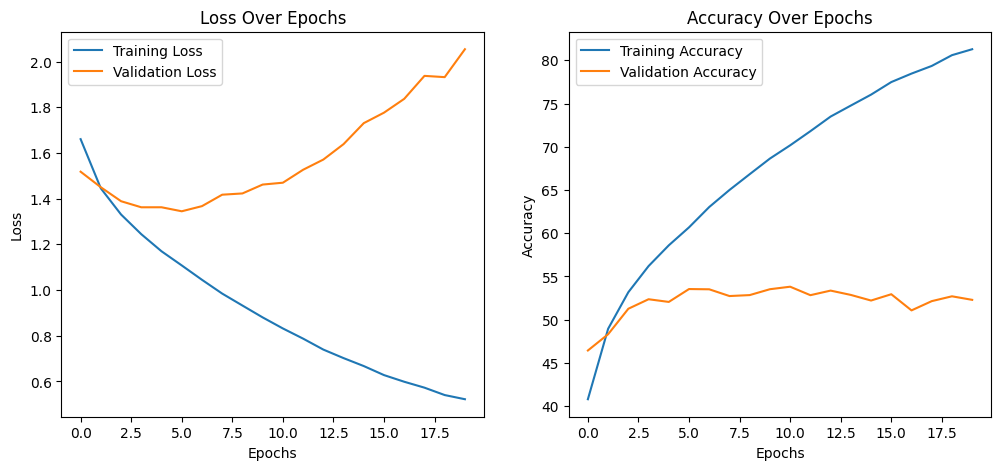


Classification Report:
              precision    recall  f1-score   support

    airplane       0.58      0.58      0.58      1000
  automobile       0.59      0.65      0.62      1000
        bird       0.44      0.38      0.41      1000
         cat       0.36      0.37      0.37      1000
        deer       0.42      0.50      0.46      1000
         dog       0.46      0.39      0.43      1000
        frog       0.56      0.58      0.57      1000
       horse       0.65      0.53      0.58      1000
        ship       0.63      0.66      0.65      1000
       truck       0.56      0.58      0.57      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.52     10000
weighted avg       0.52      0.52      0.52     10000


Confusion Matrix:


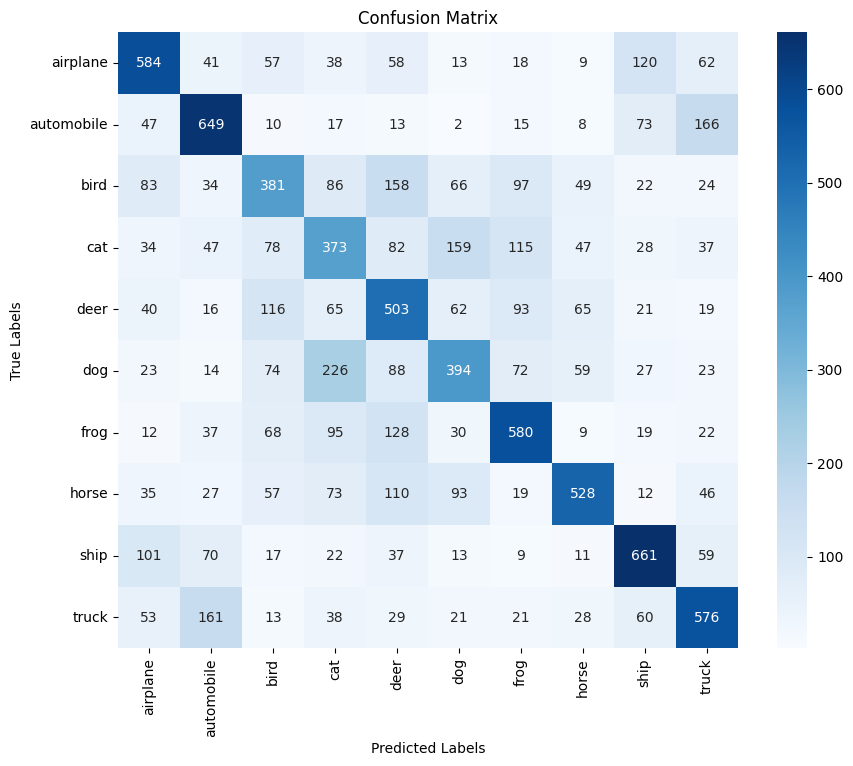

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#Pulling dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#Problem 1a
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

#sending to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

print("Training started...")
start_time = time.time()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(test_loader)
    val_acc = 100 * correct_val / total_val
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

torch.save(model.state_dict(), "mlp_cifar10.pth")

plt.figure(figsize=(12, 5))
#Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

#Evaluate the model on the test set
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

#Generate confusion matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Training started...
Epoch [1/20], Train Loss: 1.6766, Train Acc: 40.17%, Val Loss: 1.5291, Val Acc: 45.70%
Epoch [2/20], Train Loss: 1.4497, Train Acc: 48.53%, Val Loss: 1.4316, Val Acc: 49.43%
Epoch [3/20], Train Loss: 1.3358, Train Acc: 52.90%, Val Loss: 1.3747, Val Acc: 51.38%
Epoch [4/20], Train Loss: 1.2404, Train Acc: 56.15%, Val Loss: 1.3771, Val Acc: 51.93%
Epoch [5/20], Train Loss: 1.1590, Train Acc: 58.96%, Val Loss: 1.3953, Val Acc: 51.57%
Epoch [6/20], Train Loss: 1.0823, Train Acc: 61.80%, Val Loss: 1.3717, Val Acc: 54.18%
Epoch [7/20], Train Loss: 1.0050, Train Acc: 64.29%, Val Loss: 1.3635, Val Acc: 53.74%
Epoch [8/20], Train Loss: 0.9404, Train Acc: 66.48%, Val Loss: 1.4002, Val Acc: 54.01%
Epoch [9/20], Train Loss: 0.8748, Train Acc: 68.89%, Val Loss: 1.3990, Val Acc: 54.11%
Epoch [10/20], Train Loss: 0.8124, Train Acc: 70.92%, Val Loss: 1.4546, Val Acc: 54.11%
Epoch [11/20], Train Loss: 0.7492, Train Acc: 72.94%, Val Loss: 1.5325, Val Acc: 53.97%
Epoch [12/20], Train 

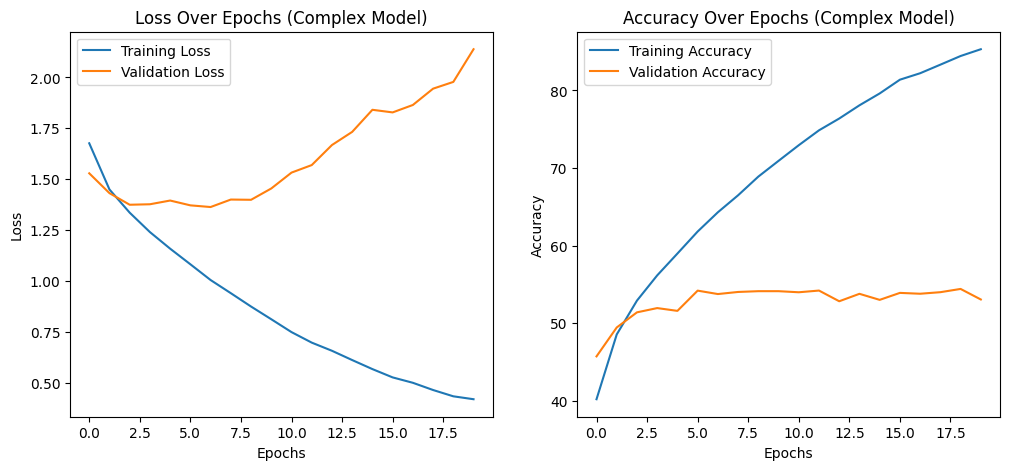


Classification Report (Problem 1b):
              precision    recall  f1-score   support

    airplane       0.60      0.55      0.57      1000
  automobile       0.66      0.63      0.64      1000
        bird       0.45      0.42      0.43      1000
         cat       0.34      0.34      0.34      1000
        deer       0.42      0.47      0.44      1000
         dog       0.46      0.43      0.45      1000
        frog       0.58      0.57      0.58      1000
       horse       0.60      0.60      0.60      1000
        ship       0.61      0.73      0.66      1000
       truck       0.60      0.55      0.57      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.53      0.53     10000


Confusion Matrix (Problem 1b):


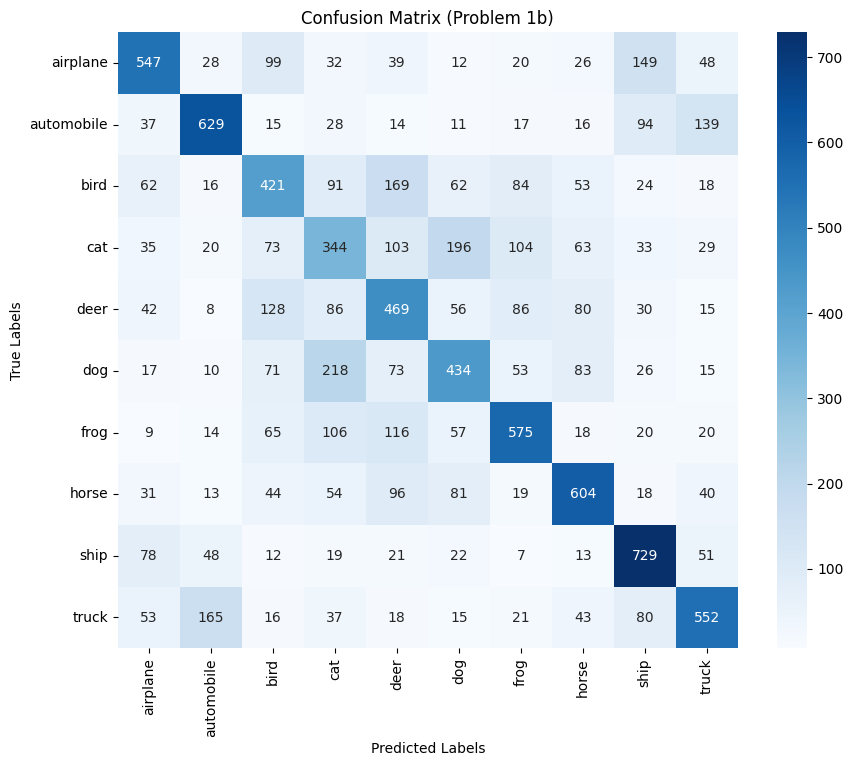

In [7]:
#Problem 1b
class ComplexMLP(nn.Module):
    def __init__(self):
        super(ComplexMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

complex_model = ComplexMLP().to(device)
optimizer = optim.Adam(complex_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 20
complex_train_loss_history, complex_val_loss_history = [], []
complex_train_acc_history, complex_val_acc_history = [], []

print("Training started...")
start_time = time.time()

for epoch in range(epochs):
    complex_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        #Forward pass
        outputs = complex_model(images)
        loss = criterion(outputs, labels)

        #Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    complex_train_loss_history.append(train_loss)
    complex_train_acc_history.append(train_acc)

    complex_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = complex_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(test_loader)
    val_acc = 100 * correct_val / total_val
    complex_val_loss_history.append(val_loss)
    complex_val_acc_history.append(val_acc)

    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

end_time = time.time()
print(f"Training for Problem 1b completed in {end_time - start_time:.2f} seconds.")

plt.figure(figsize=(12, 5))
#Loss
plt.subplot(1, 2, 1)
plt.plot(complex_train_loss_history, label='Training Loss')
plt.plot(complex_val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs (Complex Model)')

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(complex_train_acc_history, label='Training Accuracy')
plt.plot(complex_val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs (Complex Model)')

plt.show()

complex_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = complex_model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

#confusion matrix
print("\nClassification Report (Problem 1b):")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

print("\nConfusion Matrix (Problem 1b):")
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Problem 1b)')
plt.show()

Epoch [1/75], Train Loss: 0.9287, Val Loss: 0.9207
Epoch [2/75], Train Loss: 0.7061, Val Loss: 0.7008
Epoch [3/75], Train Loss: 0.5651, Val Loss: 0.6178
Epoch [4/75], Train Loss: 0.5224, Val Loss: 0.5983
Epoch [5/75], Train Loss: 0.5066, Val Loss: 0.5995
Epoch [6/75], Train Loss: 0.4987, Val Loss: 0.6019
Epoch [7/75], Train Loss: 0.4949, Val Loss: 0.6000
Epoch [8/75], Train Loss: 0.4909, Val Loss: 0.5987
Epoch [9/75], Train Loss: 0.4863, Val Loss: 0.6017
Epoch [10/75], Train Loss: 0.4831, Val Loss: 0.6046
Epoch [11/75], Train Loss: 0.4800, Val Loss: 0.6022
Epoch [12/75], Train Loss: 0.4762, Val Loss: 0.6006
Epoch [13/75], Train Loss: 0.4732, Val Loss: 0.6011
Epoch [14/75], Train Loss: 0.4672, Val Loss: 0.6021
Epoch [15/75], Train Loss: 0.4642, Val Loss: 0.6028
Epoch [16/75], Train Loss: 0.4602, Val Loss: 0.6015
Epoch [17/75], Train Loss: 0.4577, Val Loss: 0.6066
Epoch [18/75], Train Loss: 0.4498, Val Loss: 0.6015
Epoch [19/75], Train Loss: 0.4458, Val Loss: 0.6061
Epoch [20/75], Train 

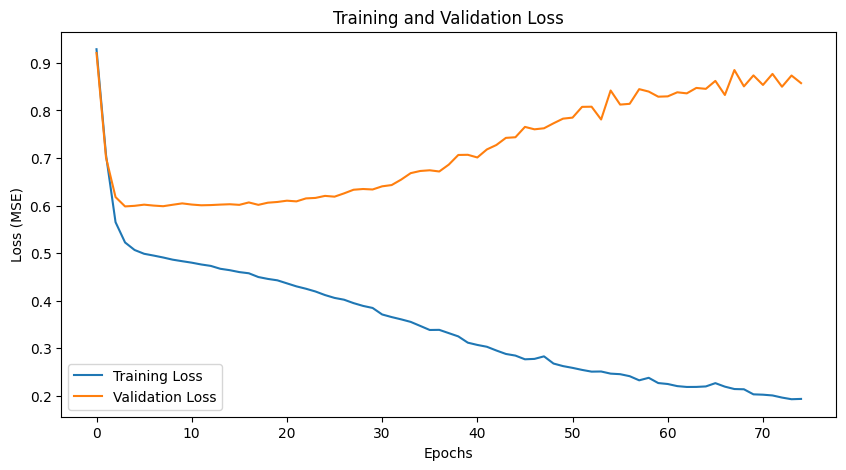

Final Validation MSE: 0.8574
Final Validation RMSE: 0.9260
Model Complexity (Total Parameters): 3185
Total Training Time: 3.22 seconds


In [22]:
#Problem 2a
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

#dataset
url = "https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/refs/heads/main/Dataset/Housing.csv"
data = pd.read_csv(url)

for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].astype('category').cat.codes

target_column = data.columns[-1]
features = data.drop([target_column], axis=1)
targets = data[target_column].values.reshape(-1, 1)

features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
scaler = StandardScaler()
features = scaler.fit_transform(features)

#split & tensor conversion
X_train, X_val, y_train, y_val = train_test_split(features, targets, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

#dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

#MLP model
class MLPHousing(nn.Module):
    def __init__(self, input_size):
        super(MLPHousing, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

#model setup
input_size = X_train.shape[1]
model = MLPHousing(input_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


#training loop
epochs = 75
train_loss_history, val_loss_history = [], []
start_time = time.time()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_loss_history.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)
    val_loss_history.append(val_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

end_time = time.time()
training_time = end_time - start_time

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

model.eval()
with torch.no_grad():
    X_val_tensor, y_val_tensor = X_val_tensor.to(device), y_val_tensor.to(device)
    y_val_pred = model(X_val_tensor)
    mse = criterion(y_val_pred, y_val_tensor).item()
    rmse = np.sqrt(mse)

print(f"Final Validation MSE: {mse:.4f}")
print(f"Final Validation RMSE: {rmse:.4f}")
print(f"Model Complexity (Total Parameters): {sum(p.numel() for p in model.parameters())}")
print(f"Total Training Time: {training_time:.2f} seconds")

Epoch [1/75], Train Loss: 0.8420, Val Loss: 0.6997
Epoch [2/75], Train Loss: 0.5784, Val Loss: 0.5822
Epoch [3/75], Train Loss: 0.5086, Val Loss: 0.5989
Epoch [4/75], Train Loss: 0.5024, Val Loss: 0.5930
Epoch [5/75], Train Loss: 0.4888, Val Loss: 0.5863
Epoch [6/75], Train Loss: 0.4806, Val Loss: 0.5925
Epoch [7/75], Train Loss: 0.4726, Val Loss: 0.5899
Epoch [8/75], Train Loss: 0.4662, Val Loss: 0.5900
Epoch [9/75], Train Loss: 0.4619, Val Loss: 0.5906
Epoch [10/75], Train Loss: 0.4509, Val Loss: 0.5946
Epoch [11/75], Train Loss: 0.4474, Val Loss: 0.5888
Epoch [12/75], Train Loss: 0.4308, Val Loss: 0.6036
Epoch [13/75], Train Loss: 0.4260, Val Loss: 0.6027
Epoch [14/75], Train Loss: 0.4284, Val Loss: 0.6142
Epoch [15/75], Train Loss: 0.4179, Val Loss: 0.6071
Epoch [16/75], Train Loss: 0.4045, Val Loss: 0.6252
Epoch [17/75], Train Loss: 0.3936, Val Loss: 0.6248
Epoch [18/75], Train Loss: 0.3808, Val Loss: 0.6330
Epoch [19/75], Train Loss: 0.3771, Val Loss: 0.6436
Epoch [20/75], Train 

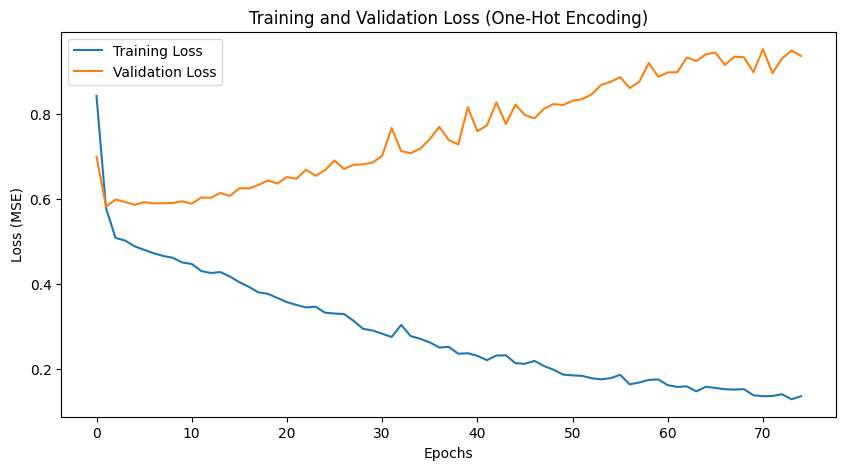

Final Validation MSE: 0.9361
Final Validation RMSE: 0.9675
Model Complexity (Total Parameters): 19689
Total Training Time: 2.65 seconds


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

url = "https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/refs/heads/main/Dataset/Housing.csv"
data_b = pd.read_csv(url)

for col in data_b.select_dtypes(include=['object']).columns:
    data_b[col] = data_b[col].astype('category').cat.codes

encoder_b = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_columns_b = data_b.select_dtypes(include=['category', 'object']).columns
encoded_categorical_b = encoder_b.fit_transform(data_b[categorical_columns_b])
encoded_categorical_b = pd.DataFrame(encoded_categorical_b, columns=encoder_b.get_feature_names_out(categorical_columns_b))
data_b = pd.concat([data_b.drop(categorical_columns_b, axis=1), encoded_categorical_b], axis=1)

target_column_b = "SalePrice"
if target_column_b not in data_b.columns:
    target_column_b = data_b.columns[-1]

features_b = data_b.drop([target_column_b], axis=1)
targets_b = data_b[target_column_b].values.reshape(-1, 1)

features_b = features_b.apply(pd.to_numeric, errors='coerce').fillna(0)
scaler_b = StandardScaler()
features_b = scaler_b.fit_transform(features_b)

X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(features_b, targets_b, test_size=0.2, random_state=42)
X_train_tensor_b = torch.tensor(X_train_b, dtype=torch.float32)
y_train_tensor_b = torch.tensor(y_train_b, dtype=torch.float32)
X_val_tensor_b = torch.tensor(X_val_b, dtype=torch.float32)
y_val_tensor_b = torch.tensor(y_val_b, dtype=torch.float32)

train_dataset_b = TensorDataset(X_train_tensor_b, y_train_tensor_b)
val_dataset_b = TensorDataset(X_val_tensor_b, y_val_tensor_b)
train_loader_b = DataLoader(dataset=train_dataset_b, batch_size=32, shuffle=True)
val_loader_b = DataLoader(dataset=val_dataset_b, batch_size=32, shuffle=False)

class MLPHousing_b(nn.Module):
    def __init__(self, input_size):
        super(MLPHousing_b, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

input_size_b = X_train_b.shape[1]
model_b = MLPHousing_b(input_size_b)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_b.to(device)
criterion_b = nn.MSELoss()
optimizer_b = optim.Adam(model_b.parameters(), lr=0.001)

epochs_b = 75
train_loss_history_b, val_loss_history_b = [], []
start_time_b = time.time()

for epoch in range(epochs_b):
    model_b.train()
    running_loss_b = 0.0
    for X_batch_b, y_batch_b in train_loader_b:
        X_batch_b, y_batch_b = X_batch_b.to(device), y_batch_b.to(device)
        optimizer_b.zero_grad()
        y_pred_b = model_b(X_batch_b)
        loss_b = criterion_b(y_pred_b, y_batch_b)
        loss_b.backward()
        optimizer_b.step()
        running_loss_b += loss_b.item() * X_batch_b.size(0)

    train_loss_b = running_loss_b / len(train_loader_b.dataset)
    train_loss_history_b.append(train_loss_b)

    model_b.eval()
    val_loss_b = 0.0
    with torch.no_grad():
        for X_batch_b, y_batch_b in val_loader_b:
            X_batch_b, y_batch_b = X_batch_b.to(device), y_batch_b.to(device)
            y_pred_b = model_b(X_batch_b)
            loss_b = criterion_b(y_pred_b, y_batch_b)
            val_loss_b += loss_b.item() * X_batch_b.size(0)

    val_loss_b /= len(val_loader_b.dataset)
    val_loss_history_b.append(val_loss_b)

    print(f"Epoch [{epoch+1}/{epochs_b}], Train Loss: {train_loss_b:.4f}, Val Loss: {val_loss_b:.4f}")

end_time_b = time.time()
training_time_b = end_time_b - start_time_b

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history_b, label='Training Loss')
plt.plot(val_loss_history_b, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss (One-Hot Encoding)')
plt.legend()
plt.show()

model_b.eval()
with torch.no_grad():
    X_val_tensor_b, y_val_tensor_b = X_val_tensor_b.to(device), y_val_tensor_b.to(device)
    y_val_pred_b = model_b(X_val_tensor_b)
    mse_b = criterion_b(y_val_pred_b, y_val_tensor_b).item()
    rmse_b = np.sqrt(mse_b)

print(f"Final Validation MSE: {mse_b:.4f}")
print(f"Final Validation RMSE: {rmse_b:.4f}")
print(f"Model Complexity (Total Parameters): {sum(p.numel() for p in model_b.parameters())}")
print(f"Total Training Time: {training_time_b:.2f} seconds")

Epoch [1/75], Train Loss: 1.0923, Val Loss: 0.7204
Epoch [2/75], Train Loss: 0.5969, Val Loss: 0.6671
Epoch [3/75], Train Loss: 0.5442, Val Loss: 0.6197
Epoch [4/75], Train Loss: 0.5150, Val Loss: 0.6243
Epoch [5/75], Train Loss: 0.4946, Val Loss: 0.6009
Epoch [6/75], Train Loss: 0.4953, Val Loss: 0.6019
Epoch [7/75], Train Loss: 0.4815, Val Loss: 0.6076
Epoch [8/75], Train Loss: 0.4775, Val Loss: 0.6135
Epoch [9/75], Train Loss: 0.4684, Val Loss: 0.6047
Epoch [10/75], Train Loss: 0.4589, Val Loss: 0.6138
Epoch [11/75], Train Loss: 0.4490, Val Loss: 0.6208
Epoch [12/75], Train Loss: 0.4526, Val Loss: 0.6249
Epoch [13/75], Train Loss: 0.4407, Val Loss: 0.6358
Epoch [14/75], Train Loss: 0.4399, Val Loss: 0.6291
Epoch [15/75], Train Loss: 0.4162, Val Loss: 0.6234
Epoch [16/75], Train Loss: 0.4069, Val Loss: 0.6494
Epoch [17/75], Train Loss: 0.4046, Val Loss: 0.6496
Epoch [18/75], Train Loss: 0.3813, Val Loss: 0.6548
Epoch [19/75], Train Loss: 0.3736, Val Loss: 0.6782
Epoch [20/75], Train 

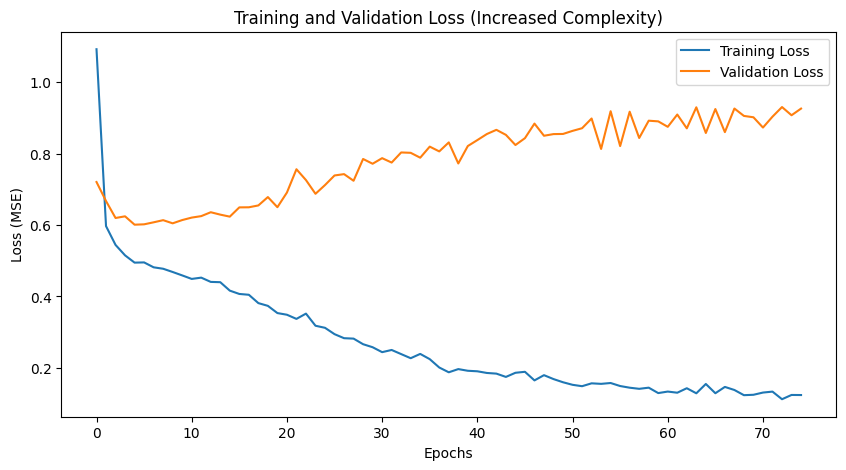

Final Validation MSE: 0.9260
Final Validation RMSE: 0.9623
Model Complexity (Total Parameters): 46593
Total Training Time: 3.71 seconds


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

url = "https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/refs/heads/main/Dataset/Housing.csv"
data_c = pd.read_csv(url)

for col in data_c.select_dtypes(include=['object']).columns:
    data_c[col] = data_c[col].astype('category').cat.codes

encoder_c = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_columns_c = data_c.select_dtypes(include=['category', 'object']).columns
encoded_categorical_c = encoder_c.fit_transform(data_c[categorical_columns_c])
encoded_categorical_c = pd.DataFrame(encoded_categorical_c, columns=encoder_c.get_feature_names_out(categorical_columns_c))
data_c = pd.concat([data_c.drop(categorical_columns_c, axis=1), encoded_categorical_c], axis=1)

target_column_c = "SalePrice"
if target_column_c not in data_c.columns:
    target_column_c = data_c.columns[-1]

features_c = data_c.drop([target_column_c], axis=1)
targets_c = data_c[target_column_c].values.reshape(-1, 1)

features_c = features_c.apply(pd.to_numeric, errors='coerce').fillna(0)
scaler_c = StandardScaler()
features_c = scaler_c.fit_transform(features_c)

X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(features_c, targets_c, test_size=0.2, random_state=42)
X_train_tensor_c = torch.tensor(X_train_c, dtype=torch.float32)
y_train_tensor_c = torch.tensor(y_train_c, dtype=torch.float32)
X_val_tensor_c = torch.tensor(X_val_c, dtype=torch.float32)
y_val_tensor_c = torch.tensor(y_val_c, dtype=torch.float32)

train_dataset_c = TensorDataset(X_train_tensor_c, y_train_tensor_c)
val_dataset_c = TensorDataset(X_val_tensor_c, y_val_tensor_c)
train_loader_c = DataLoader(dataset=train_dataset_c, batch_size=32, shuffle=True)
val_loader_c = DataLoader(dataset=val_dataset_c, batch_size=32, shuffle=False)

class MLPHousing_c(nn.Module):
    def __init__(self, input_size):
        super(MLPHousing_c, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

input_size_c = X_train_c.shape[1]
model_c = MLPHousing_c(input_size_c)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_c.to(device)
criterion_c = nn.MSELoss()
optimizer_c = optim.Adam(model_c.parameters(), lr=0.001)

epochs_c = 75
train_loss_history_c, val_loss_history_c = [], []
start_time_c = time.time()

for epoch in range(epochs_c):
    model_c.train()
    running_loss_c = 0.0
    for X_batch_c, y_batch_c in train_loader_c:
        X_batch_c, y_batch_c = X_batch_c.to(device), y_batch_c.to(device)
        optimizer_c.zero_grad()
        y_pred_c = model_c(X_batch_c)
        loss_c = criterion_c(y_pred_c, y_batch_c)
        loss_c.backward()
        optimizer_c.step()
        running_loss_c += loss_c.item() * X_batch_c.size(0)

    train_loss_c = running_loss_c / len(train_loader_c.dataset)
    train_loss_history_c.append(train_loss_c)

    model_c.eval()
    val_loss_c = 0.0
    with torch.no_grad():
        for X_batch_c, y_batch_c in val_loader_c:
            X_batch_c, y_batch_c = X_batch_c.to(device), y_batch_c.to(device)
            y_pred_c = model_c(X_batch_c)
            loss_c = criterion_c(y_pred_c, y_batch_c)
            val_loss_c += loss_c.item() * X_batch_c.size(0)

    val_loss_c /= len(val_loader_c.dataset)
    val_loss_history_c.append(val_loss_c)

    print(f"Epoch [{epoch+1}/{epochs_c}], Train Loss: {train_loss_c:.4f}, Val Loss: {val_loss_c:.4f}")

end_time_c = time.time()
training_time_c = end_time_c - start_time_c

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history_c, label='Training Loss')
plt.plot(val_loss_history_c, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss (Increased Complexity)')
plt.legend()
plt.show()

model_c.eval()
with torch.no_grad():
    X_val_tensor_c, y_val_tensor_c = X_val_tensor_c.to(device), y_val_tensor_c.to(device)
    y_val_pred_c = model_c(X_val_tensor_c)
    mse_c = criterion_c(y_val_pred_c, y_val_tensor_c).item()
    rmse_c = np.sqrt(mse_c)

print(f"Final Validation MSE: {mse_c:.4f}")
print(f"Final Validation RMSE: {rmse_c:.4f}")
print(f"Model Complexity (Total Parameters): {sum(p.numel() for p in model_c.parameters())}")
print(f"Total Training Time: {training_time_c:.2f} seconds")
